In [1]:
import ARESlatticeStage3v1_9 as ares
import cheetah
import matplotlib.pyplot as plt
import torch

/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/beam.py:1567: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  slice_analysis = slice_analysis_py if not nb_flag else nb.jit(slice_analysis_py)
/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.9/site-packages/ocelot/cpbd/tm_utils.py:153: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavi

initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


### Loading the lattice

The lattice is available in Ocelot's format, so we use the `from_ocelot` class method of `Segement`. Because we only care about the Experimental Area (EA), we then select a subcell of the lattice file of the entire ARES accelerator.

Unlike Cheetah, Ocelot does not support screens. Therefore, when Oceloet `Marker`s have the substiring `"screen"` in their name, Cheetah creates a `Screen` element with default properties and emits a warning about this. We can than manually set the correct screen properties.


In [2]:
segment = cheetah.Segment.from_ocelot(ares.cell, warnings=False).subcell(
    "AREASOLA1", "AREABSCR1"
)

# Manually set screen properties
segment.AREABSCR1.resolution = torch.tensor((2448, 2040), dtype=torch.float32)
segment.AREABSCR1.pixel_size = torch.tensor((3.3198e-6, 2.4469e-6), dtype=torch.float32)

# Set some values on the magnets
segment.AREAMQZM1.k1 = torch.tensor(10.0, dtype=torch.float32)
segment.AREAMQZM2.k1 = torch.tensor(-9.0, dtype=torch.float32)
segment.AREAMCVM1.angle = torch.tensor(1e-3, dtype=torch.float32)
segment.AREAMQZM3.k1 = torch.tensor(-8.0, dtype=torch.float32)
segment.AREAMCHM1.angle = torch.tensor(-2e-3, dtype=torch.float32)

segment

Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750))
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(10.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280))
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(-9.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040))
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.0010), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040))
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(-8.), misalignment=tensor([0., 0.]), tilt=tensor(0.), name='AREAMQZM3')
  (9): Drift(length=tensor(0.1790))
  (10): HorizontalCorrector(length=tensor(0.0200), angle=tensor(-0.0020), name='AREAMCHM1')
  (11): Drift(length=tensor(0.4500))
  (12): Screen(resolution=tensor([2448., 2040.]), pixel_size=tensor([3.3198e-06, 2.4469e-06]), binning=tensor(1), misalignment=tensor([0., 0.]), is_active=False, name='AREAB

### Load particle distribution

We load the beam both as a `ParameterBeam` and a `ParticleBeam` in order to test Cheetah's speed in both its fastest as well as its full particle tracking mode.


In [3]:
parameter_beam = cheetah.ParameterBeam.from_astra(
    "ACHIP_EA1_2021.1351.001", device="cpu"
)
parameter_beam

ParameterBeam(mu_x=tensor(8.2413e-07), mu_xp=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_yp=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_xp=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_yp=tensor(3.6941e-06), sigma_s=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)), total_charge=tensor(5.0000e-13))

In [4]:
particle_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001", device="cpu")
particle_beam

ParticleBeam(n=100000, mu_x=tensor(8.2413e-07), mu_xp=tensor(5.9885e-08), mu_y=tensor(-1.7276e-06), mu_yp=tensor(-1.1746e-07), sigma_x=tensor(0.0002), sigma_xp=tensor(3.6794e-06), sigma_y=tensor(0.0002), sigma_yp=tensor(3.6941e-06), sigma_s=tensor(8.0116e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

### Benchmark

We first start with a simple benchmark just tracking particles.


In [5]:
optimized_segment = segment.transfer_maps_merged(incoming_beam=particle_beam)

#### Parameter Beam


In [6]:
segment.AREABSCR1.is_active = False

In [7]:
%%timeit
outgoing = segment.track(parameter_beam)

758 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
%%timeit
outgoing = optimized_segment.track(parameter_beam)

21.1 µs ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
outgoing = segment.track(parameter_beam)
outgoing

ParameterBeam(mu_x=tensor(-0.0009), mu_xp=tensor(-0.0020), mu_y=tensor(0.0008), mu_yp=tensor(0.0007), sigma_x=tensor(0.0001), sigma_xp=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_yp=tensor(0.0003), sigma_s=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)), total_charge=tensor(5.0000e-13))

We continue with a benchmark tracking particles and then reading the screen.


In [10]:
segment.AREABSCR1.is_active = True

In [11]:
%%timeit
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

29.1 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


I'm an empty beam!


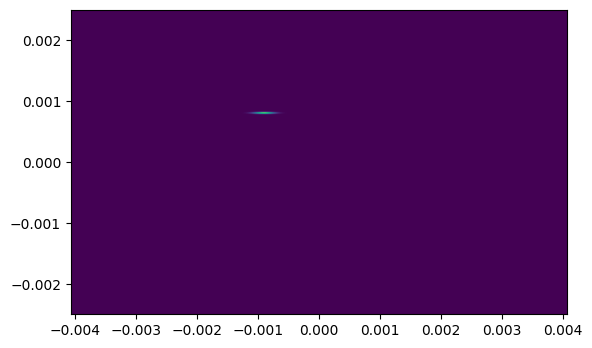

In [12]:
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()

#### Particle Beam


In [13]:
segment.AREABSCR1.is_active = False

In [14]:
%%timeit
outgoing = segment.track(particle_beam)

1.6 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%timeit
outgoing = optimized_segment.track(particle_beam)

786 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
outgoing = segment(particle_beam)
outgoing

ParticleBeam(n=100000, mu_x=tensor(-0.0009), mu_xp=tensor(-0.0020), mu_y=tensor(0.0008), mu_yp=tensor(0.0007), sigma_x=tensor(0.0001), sigma_xp=tensor(0.0001), sigma_y=tensor(9.2004e-06), sigma_yp=tensor(0.0003), sigma_s=tensor(7.9948e-06), sigma_p=tensor(0.0023), energy=tensor(1.0732e+08)) total_charge=tensor(5.0000e-13))

We continue with a benchmark tracking particles and then reading the screen.


In [17]:
segment.AREABSCR1.is_active = True

In [18]:
%%timeit
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

15.8 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


I'm an empty beam!


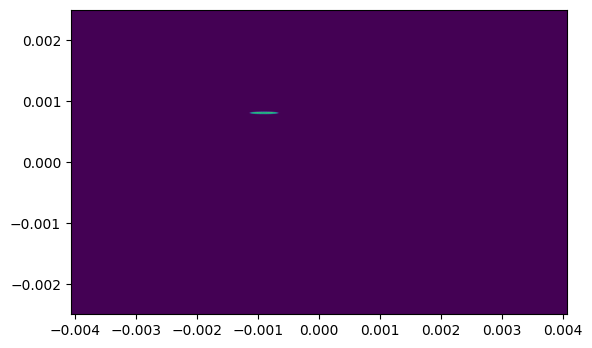

In [19]:
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()